In [66]:
import datetime as dt
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [67]:
import sys
import os

project_root = os.path.abspath('..')
sys.path.append(project_root)

from models.custom_regression_tree import CustomRegressionTree
from models.custom_random_forest import CustomRandomForest

In [68]:
DATA_PATH = os.path.join(project_root, "data")
RANDOM_STATE = 42
LABEL_COL = "retailvalue"

In [69]:
def get_scores(reals: np.array, preds: np.array) -> dict:
    rmse = np.sqrt(np.mean((preds - reals)**2))
    mape = np.mean(np.abs((reals - preds) / reals)) * 100

    return {"RMSE": rmse, "MAPE": mape}

def generate_cv_summary(model_scores: dict, metric: str = "RMSE") -> None:
    num_models = len(model_scores.keys())
    fig, ax = plt.subplots(1, num_models, figsize=(35,5))
    if num_models == 1:
        ax = [ax]

    min_metric, max_metric = None, None

    all_metrics = [metric_val for model in model_scores.values() for metric_val in model[metric]]
    min_metric, max_metric = np.min(all_metrics), np.max(all_metrics)

    summaries = []
    
    for i, items in enumerate(model_scores.items()):
        k, v = items

        sns.boxplot(v[metric], ax=ax[i])
        ax[i].set_ylim(min_metric*0.9, max_metric*1.1)
        ax[i].set_xlabel(k.replace("@", "\n"))
        ax[i].axhline(((max_metric-min_metric)/2)+min_metric, linestyle="--", c="red")

        summary = {"MODEL": k, "METRIC": metric, "MEAN": np.mean(v[metric]), "MIN": np.min(v[metric]), "MAX": np.max(v[metric]), "STD_DEV": np.std(v[metric])}
        summaries.append(summary)
    df_summary = pd.DataFrame(summaries)
    display(df_summary)
    
    fig.suptitle("Cross-validation for model parameters", fontsize=16)
    plt.tight_layout()

    return df_summary

def create_model_name(model: str, params: dict) -> str:
    model_name = model + "@" + str(params).replace(":", "=").replace(" ", "").replace("'", "")
    return model_name

In [70]:
df_utrecht = pd.read_csv(os.path.join(DATA_PATH, "utrechthousingsmall.csv"))
df_utrecht.head()

,id,zipcode,lot-len,lot-width,lot-area,house-area,garden-size,balcony,x-coor,y-coor,buildyear,bathrooms,taxvalue,retailvalue,energy-eff,monument,select
0,150219,3528,10.7,5.2,55.6,93.60,5.2,0,2068,5055,1935,1,419000,568000,0,1,0
1,880377,3800,18.6,6.2,115.3,111.60,40.9,2,2861,5056,1927,1,539000,649000,0,1,0
2,110456,3528,12.7,5.2,66.0,117.00,5.2,0,2267,5118,1941,1,521000,716000,0,1,0
3,520728,3800,16.2,6.3,102.1,141.75,26.5,2,2615,5150,1940,1,649000,825000,0,1,0
4,881551,3800,17.6,8.1,142.6,182.25,69.7,2,2756,5359,1960,1,843000,1015000,0,1,0


## Feature Engineering

In [71]:
## Dropping unnecessary columns
df = df_utrecht.copy()
df = df.drop(columns = ['id', 'lot-len','lot-width','x-coor','y-coor', 'taxvalue'])

In [72]:
# Converting column buildyear to house_age
df['house_age'] = 2025 - df['buildyear']
df.drop(columns=['buildyear'], inplace=True)

In [73]:
## One hot encoding possibly categorical columns
df = pd.get_dummies(df, columns = ['zipcode'], prefix = 'zip')

<Axes: ylabel='retailvalue'>

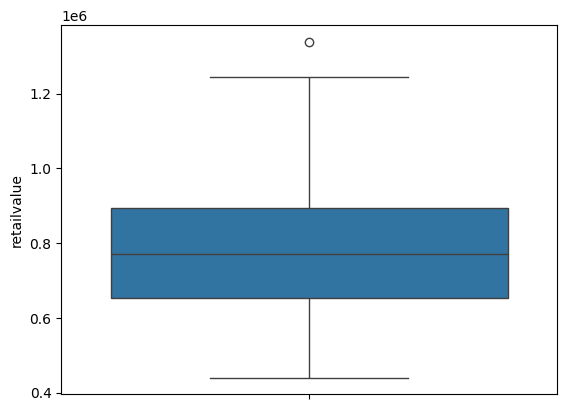

In [74]:
sns.boxplot(df[LABEL_COL])

# Modeling

## Train-test(holdout) split

In [75]:
df_train, df_test = train_test_split(df, train_size = 0.8, shuffle=True, random_state=RANDOM_STATE)
df_train.shape, df_test.shape

((80, 14), (20, 14))

## Cross-Validation

In [77]:
cust_reg_tree_param_grid = [
    {"max_depth":2, "min_samples_split":5},
    {"max_depth":3, "min_samples_split":5},
    {"max_depth":4, "min_samples_split":5},
    {"max_depth":3, "min_samples_split":10},
    {"max_depth":4, "min_samples_split":10},
]

cust_rand_forest_param_grid = [
    {"n_trees": 25, "max_depth": 3, "min_samples_split": 10, "max_features": 13},
    {"n_trees":50, "max_depth":5, "min_samples_split":5, "max_features":13},
    {"n_trees": 50, "max_depth": 3, "min_samples_split": 10, "max_features": 13},
    {"n_trees": 50, "max_depth": 4, "min_samples_split": 10, "max_features": 13},
    {"n_trees": 50, "max_depth": 3, "min_samples_split": 15, "max_features": 13},
    {"n_trees": 75, "max_depth": 3, "min_samples_split": 10, "max_features": 13},
]

sklearn_tree_reg_param_grid = [
    {"max_depth":2, "min_samples_split":5},
    {"max_depth":3, "min_samples_split":5},
    {"max_depth":4, "min_samples_split":5},
    {"max_depth":3, "min_samples_split":10},
    {"max_depth":4, "min_samples_split":10},
]

sklearn_rand_forest_param_grid = [
    {"max_depth":3, "min_samples_split":5, "n_estimators":50},
    {"max_depth":4, "min_samples_split":5, "n_estimators":50},
    {"max_depth":5, "min_samples_split":5, "n_estimators":50},
]

sklearn_linear_reg_param_grid = [
    {"alpha": 0.01, "max_iter": 2000},
    {"alpha": 0.1, "max_iter": 2000},
    {"alpha": 0.5, "max_iter": 2000},
    {"alpha": 1.0, "max_iter": 2000},
    {"alpha": 5.0, "max_iter": 2000},
    {"alpha": 10.0, "max_iter": 2000},
]

In [78]:
kf = KFold(n_splits = 5, shuffle=True, random_state = RANDOM_STATE)

feat_cols = [col for col in df_train if col != LABEL_COL]

numeric_features = df_train[feat_cols].select_dtypes(include = ['number', 'bool']).columns.tolist()

model_scores = {}

for train_idx, validation_idx in kf.split(df_train):
    X_train_raw = df_train.iloc[train_idx][feat_cols]
    X_validation_raw = df_train.iloc[validation_idx][feat_cols]

    y = df_train[LABEL_COL].values
    y_train, y_validation = y[train_idx], y[validation_idx]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ]
    )

    X_train = preprocessor.fit_transform(X_train_raw)
    X_validation = preprocessor.transform(X_validation_raw)

    print("Cross-validating Custom Regression Tree")
    for params in cust_reg_tree_param_grid:
        model = "CUSTOM_REGRESSION_TREE"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}

        custom_reg_tree_model = CustomRegressionTree(**params)
        custom_reg_tree_model.fit(X_train, y_train)
    
        custom_reg_tree_preds = custom_reg_tree_model.predict(X_validation)
        
        custom_reg_tree_metrics = get_scores(reals=y_validation, preds=custom_reg_tree_preds)
        model_scores[model_name]["RMSE"].append(custom_reg_tree_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(custom_reg_tree_metrics["MAPE"])

    print("Cross-validating Sklearn Regression Tree")
    for params in sklearn_tree_reg_param_grid:
        model = "SKLEARN_REGRESSION_TREE"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}
        tree_regressor = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)
        tree_regressor.fit(X_train, y_train)
    
        tree_regressor_preds = tree_regressor.predict(X_validation)
        
        reg_tree_metrics = get_scores(reals=y_validation, preds=tree_regressor_preds)
        model_scores[model_name]["RMSE"].append(reg_tree_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(reg_tree_metrics["MAPE"])
    
    print("Cross-validating Custom Random Forest")
    for params in cust_rand_forest_param_grid:
        model = "CUSTOM_RANDOM_FOREST"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}
        
        cust_rand_forest = CustomRandomForest(**params, random_state=RANDOM_STATE)
        cust_rand_forest.fit(X_train, y_train)
        
        cust_rand_forest_preds = cust_rand_forest.predict(X_validation)
        
        cust_rand_forest_metrics = get_scores(reals=y_validation, preds=cust_rand_forest_preds)
        model_scores[model_name]["RMSE"].append(cust_rand_forest_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(cust_rand_forest_metrics["MAPE"])

    print("Cross-validating Sklearn Random Forest Regressor")
    for params in sklearn_rand_forest_param_grid:
        model = "SKLEARN_RANDOM_FOREST"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}
        rand_forest_regr = RandomForestRegressor(**params, random_state=RANDOM_STATE)
        rand_forest_regr.fit(X_train, y_train)

        rand_forest_preds = rand_forest_regr.predict(X_validation)
        
        rand_forest_metrics = get_scores(reals=y_validation, preds=rand_forest_preds)
        model_scores[model_name]["RMSE"].append(rand_forest_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(rand_forest_metrics["MAPE"])

    print("Cross-validating Sklearn Linear Regressor")
    for params in sklearn_linear_reg_param_grid:
        model = "SKLEARN_LINEAR_REGRESSOR"
        model_name = create_model_name(model=model, params=params)
        if model_name not in model_scores.keys():
            model_scores[model_name] = {"RMSE": [], "MAPE": []}
        lasso_regr = linear_model.Lasso(**params, random_state=RANDOM_STATE)
        lasso_regr.fit(X_train, y_train)

        lasso_preds = lasso_regr.predict(X_validation)
        
        lasso_metrics = get_scores(reals=y_validation, preds=lasso_preds)
        model_scores[model_name]["RMSE"].append(lasso_metrics["RMSE"])
        model_scores[model_name]["MAPE"].append(lasso_metrics["MAPE"])

Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Custom Random Forest
Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Custom Random Forest


/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+09, tolerance: 2.051e+08
  model = cd_fast.enet_coordinate_descent(
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e+09, tolerance: 2.051e+08
  model = cd_fast.enet_coordinate_descent(
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase 

Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Custom Random Forest
Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Custom Random Forest


/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+09, tolerance: 1.745e+08
  model = cd_fast.enet_coordinate_descent(
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e+09, tolerance: 1.745e+08
  model = cd_fast.enet_coordinate_descent(
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase 

Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor
Cross-validating Custom Regression Tree
Cross-validating Sklearn Regression Tree
Cross-validating Custom Random Forest


/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+09, tolerance: 2.093e+08
  model = cd_fast.enet_coordinate_descent(
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+09, tolerance: 2.093e+08
  model = cd_fast.enet_coordinate_descent(
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase 

Cross-validating Sklearn Random Forest Regressor
Cross-validating Sklearn Linear Regressor


In [79]:
unique_model_types = set([k.split("@")[0] for k in model_scores.keys()])
unique_model_types

{'CUSTOM_RANDOM_FOREST',
 'CUSTOM_REGRESSION_TREE',
 'SKLEARN_LINEAR_REGRESSOR',
 'SKLEARN_RANDOM_FOREST',
 'SKLEARN_REGRESSION_TREE'}

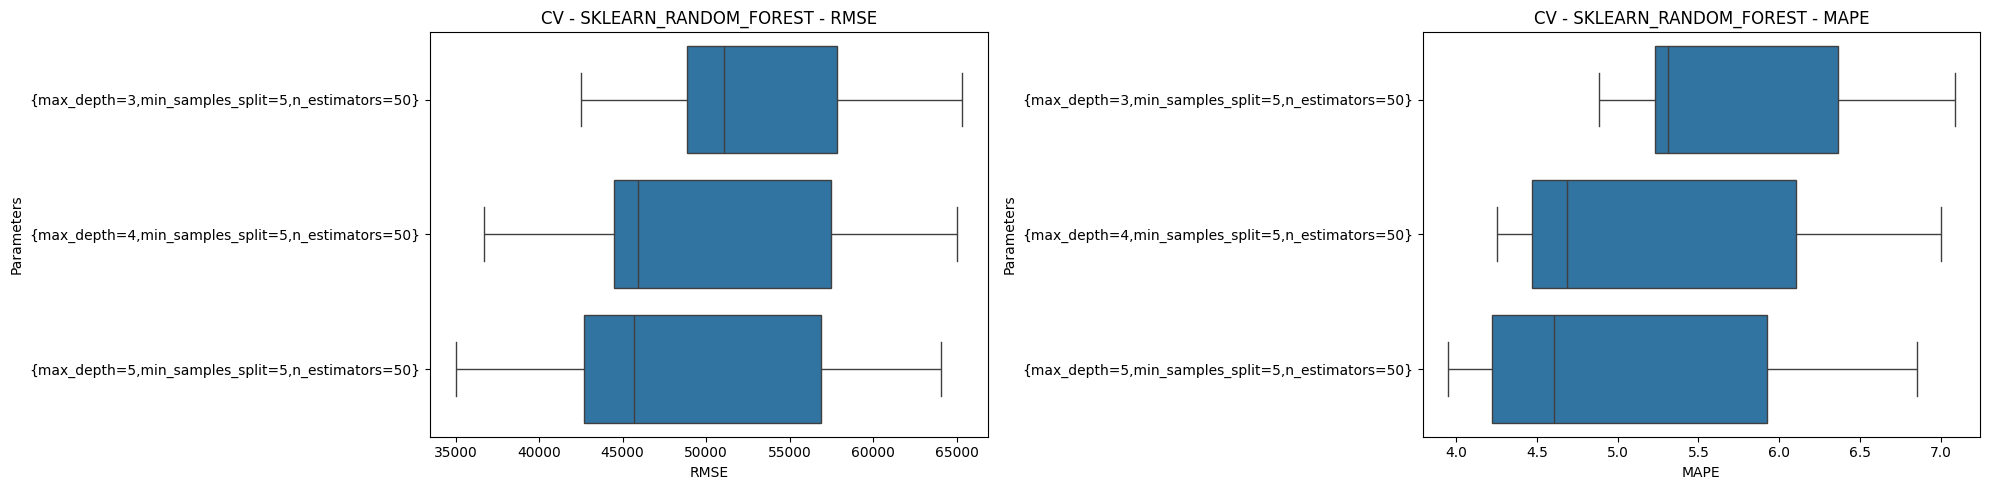

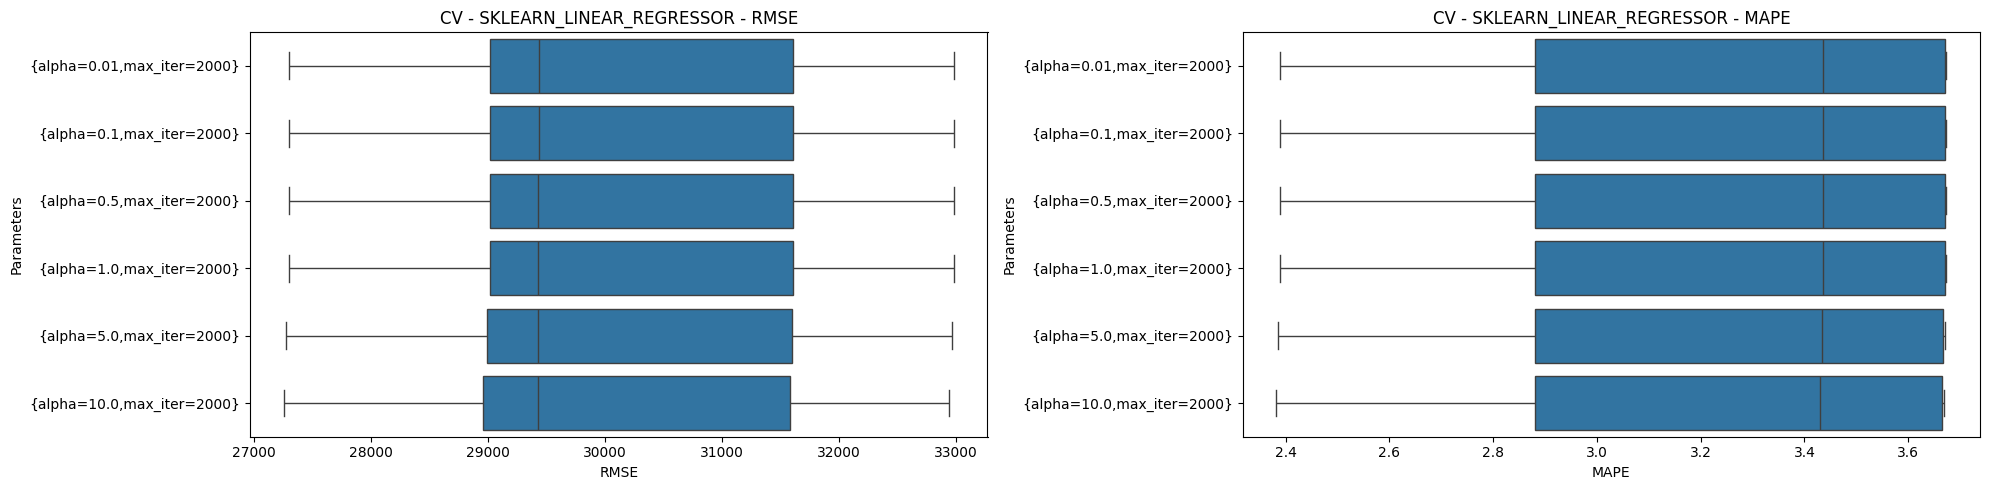

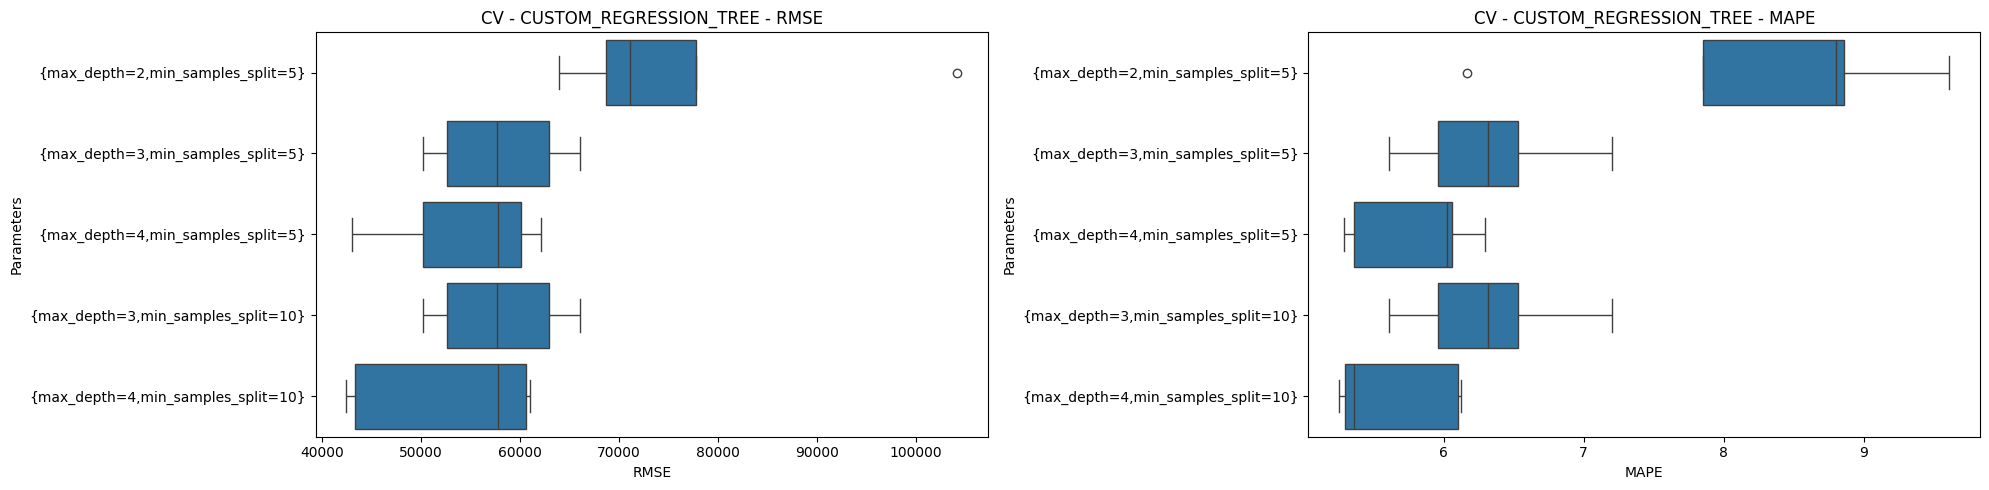

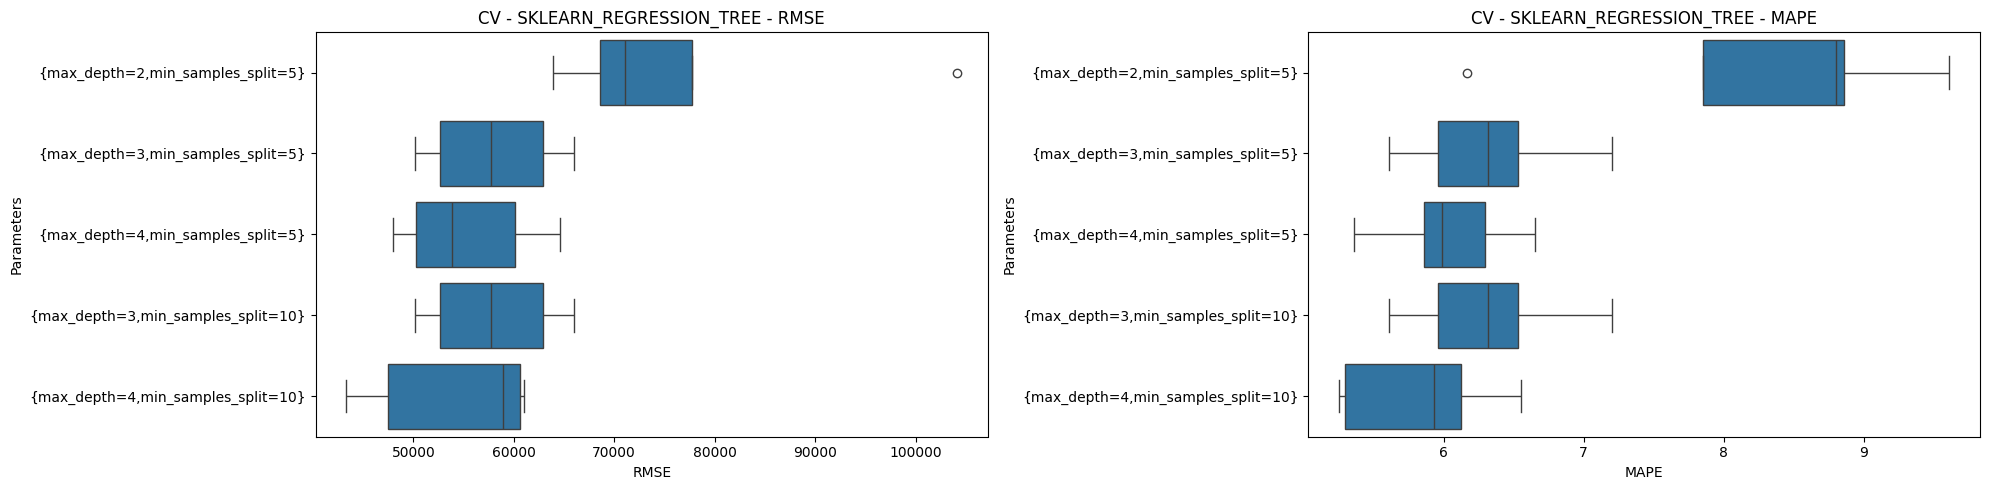

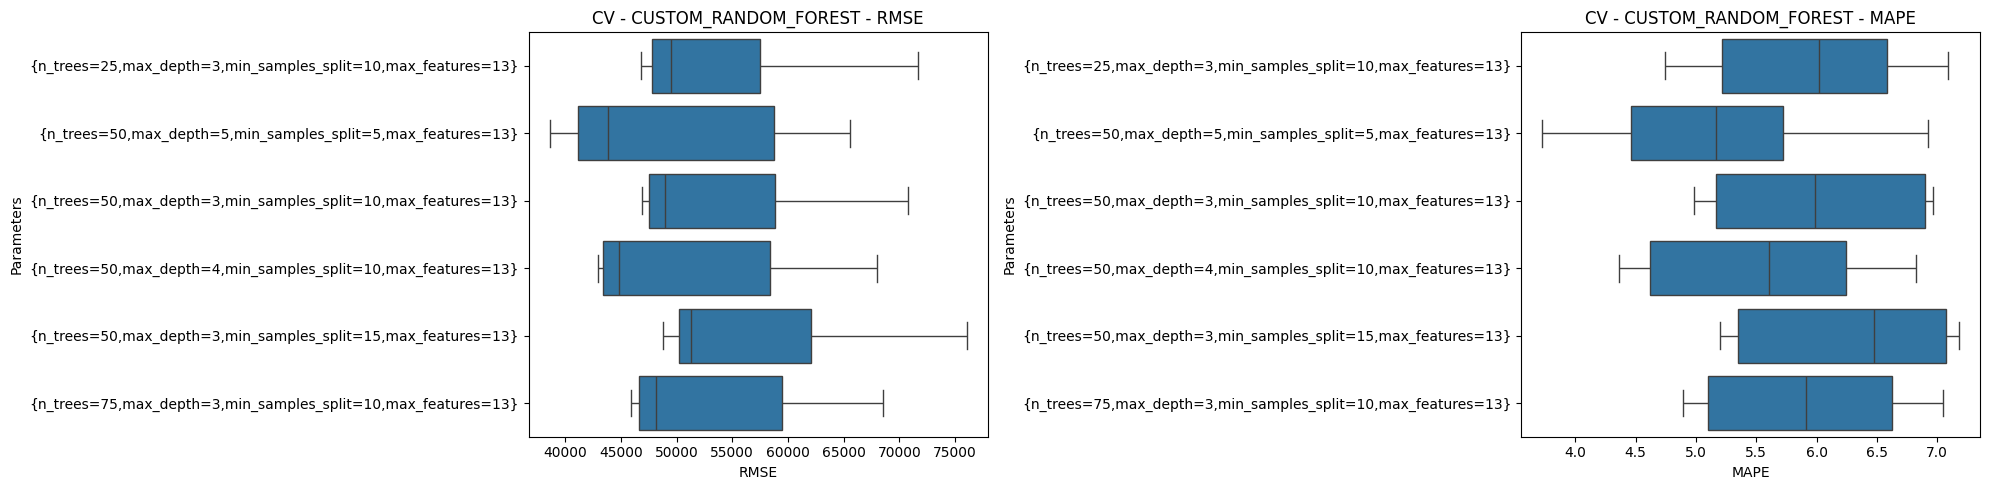

In [80]:
dfs_agg = []

for model_type in unique_model_types:
    model_scores_model_type = {k: v for k,v in model_scores.items() if model_type in k}
    dfs_model_type = []
    for k,v in model_scores_model_type.items():
        model, params = k.split("@")
        vals = v
        for metric_name, metric_vals in v.items():
            params_match = re.findall(r"([^={},\s]+)=([^={},\s]+)", params)
            df_part = pd.DataFrame([{"MODEL": model, "PARAMS": params, "METRIC": metric_name, "FOLD": fold, "VALS": m_val} for fold, m_val in enumerate(metric_vals)])
            df_part['param_dict'] = df_part['PARAMS'].apply(
                                                lambda s: dict(re.findall(r"([^={},\s]+)=([^={},\s]+)", s))
                                            )
            df_part = df_part.join(df_part['param_dict'].apply(pd.Series))
            df_part = df_part.drop("param_dict", axis=1)
            dfs_model_type.append(df_part)
            
    df_detail = pd.concat(dfs_model_type)
    df_detail

    if "max_depth" in df_detail.columns:
        df_detail["max_depth"] = df_detail["max_depth"].astype(int)
    if "min_samples_split" in df_detail.columns:
        df_detail["min_samples_split"] = df_detail["min_samples_split"].astype(int)
    if "alpha" in df_detail.columns:
        df_detail["alpha"] = df_detail["alpha"].astype(float)
    df_detail
    
    # plt.figure()
    # sns.scatterplot(data=df_detail[df_detail["METRIC"] == "RMSE"], x="max_depth", y="min_samples_split", size="VALS")

    metrics = df_detail["METRIC"].unique()
    fig, ax = plt.subplots(1,2, figsize=(20, 5))
    for i, metric in enumerate(metrics):
        df_detail_metric = df_detail[df_detail["METRIC"] == metric]
        sns.boxplot(data=df_detail_metric, x="VALS", y="PARAMS", ax=ax[i])
        ax[i].set_ylabel("Parameters")
        ax[i].set_xlabel(metric)
        ax[i].title.set_text(f"CV - {model} - {metric}")
    plt.tight_layout()

    df_detail_agg = df_detail.groupby(["MODEL", "PARAMS", "METRIC"])["VALS"].agg(["mean", "min", "max", "std"])
    dfs_agg.append(df_detail_agg)

In [81]:
df_agg_final = pd.concat(dfs_agg).reset_index()
df_agg_final['FINAL_SCORE'] = df_agg_final['mean'] + df_agg_final['std']

df_agg_final = df_agg_final.sort_values(by=["MODEL", "FINAL_SCORE"])

for model in df_agg_final["MODEL"].unique():
    df_unique_model = df_agg_final[(df_agg_final["MODEL"] == model)].sort_values(by="FINAL_SCORE")
    
    display(df_unique_model.pivot(index=["MODEL", "PARAMS"], columns="METRIC").sort_values(("FINAL_SCORE", "RMSE"), ascending=True))  

mean  \
METRIC                                                                       MAPE   
MODEL                PARAMS                                                         
CUSTOM_RANDOM_FOREST {n_trees=50,max_depth=5,min_samples_split=5,max...  5.201196   
                     {n_trees=50,max_depth=4,min_samples_split=10,ma...  5.532397   
                     {n_trees=75,max_depth=3,min_samples_split=10,ma...  5.915837   
                     {n_trees=50,max_depth=3,min_samples_split=10,ma...  5.998802   
                     {n_trees=25,max_depth=3,min_samples_split=10,ma...  5.931257   
                     {n_trees=50,max_depth=3,min_samples_split=15,ma...  6.256045   

                                                                                       \
METRIC                                                                           RMSE   
MODEL                PARAMS                                                             
CUSTOM_RANDOM_FOREST {n_trees=50,max_depth=5,min_samples_split=5,max...  49601.566842   
                     {n_trees=50,max_depth=4,min_samples_split=10,ma...  51528.277247   
                     {n_trees=75,max_depth=3,min_samples_split=10,ma...  53741.109086   
                     {n_trees=50,max_depth=3,min_samples_split=10,ma...  54588.274455   
                     {n_trees=25,max_depth=3,min_samples_split=10,ma...  54663.258698   
                     {n_trees=50,max_depth=3,min_samples_split=15,ma...  57690.744628   

                                                                              min  \
METRIC                                                                       MAPE   
MODEL                PARAMS                                                         
CUSTOM_RANDOM_FOREST {n_trees=50,max_depth=5,min_samples_split=5,max...  3.723210   
                     {n_trees=50,max_depth=4,min_samples_split=10,ma...  4.359987   
                     {n_trees=75,max_depth=3,min_samples_split=10,ma...  4.891449   
                     {n_trees=50,max_depth=3,min_samples_split=10,ma...  4.981083   
                     {n_trees=25,max_depth=3,min_samples_split=10,ma...  4.740710   
                     {n_trees=50,max_depth=3,min_samples_split=15,ma...  5.196399   

                                                                                       \
METRIC                                                                           RMSE   
MODEL                PARAMS                                                             
CUSTOM_RANDOM_FOREST {n_trees=50,max_depth=5,min_samples_split=5,max...  38614.288107   
                     {n_trees=50,max_depth=4,min_samples_split=10,ma...  42970.539181   
                     {n_trees=75,max_depth=3,min_samples_split=10,ma...  45921.114994   
                     {n_trees=50,max_depth=3,min_samples_split=10,ma...  46884.217197   
                     {n_trees=25,max_depth=3,min_samples_split=10,ma...  46834.457744   
                     {n_trees=50,max_depth=3,min_samples_split=15,ma...  48793.740087   

                                                                              max  \
METRIC                                                                       MAPE   
MODEL                PARAMS                                                         
CUSTOM_RANDOM_FOREST {n_trees=50,max_depth=5,min_samples_split=5,max...  6.924793   
                     {n_trees=50,max_depth=4,min_samples_split=10,ma...  6.826655   
                     {n_trees=75,max_depth=3,min_samples_split=10,ma...  7.048894   
                     {n_trees=50,max_depth=3,min_samples_split=10,ma...  6.963468   
                     {n_trees=25,max_depth=3,min_samples_split=10,ma...  7.090255   
                     {n_trees=50,max_depth=3,min_samples_split=15,ma...  7.183714   

                                                                                       \
METRIC                                                                           RMSE 

mean  \
METRIC                                                         MAPE   
MODEL                  PARAMS                                         
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=10}  5.627503   
                       {max_depth=4,min_samples_split=5}   5.806020   
                       {max_depth=3,min_samples_split=5}   6.324225   
                       {max_depth=3,min_samples_split=10}  6.324225   
                       {max_depth=2,min_samples_split=5}   8.257331   

                                                                         \
METRIC                                                             RMSE   
MODEL                  PARAMS                                             
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=10}  53046.997555   
                       {max_depth=4,min_samples_split=5}   54654.641146   
                       {max_depth=3,min_samples_split=5}   57905.094814   
                       {max_depth=3,min_samples_split=10}  57905.094814   
                       {max_depth=2,min_samples_split=5}   77105.418887   

                                                                min  \
METRIC                                                         MAPE   
MODEL                  PARAMS                                         
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=10}  5.253097   
                       {max_depth=4,min_samples_split=5}   5.291956   
                       {max_depth=3,min_samples_split=5}   5.608423   
                       {max_depth=3,min_samples_split=10}  5.608423   
                       {max_depth=2,min_samples_split=5}   6.165513   

                                                                         \
METRIC                                                             RMSE   
MODEL                  PARAMS                                             
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=10}  42469.157101   
                       {max_depth=4,min_samples_split=5}   43052.742095   
                       {max_depth=3,min_samples_split=5}   50210.620403   
                       {max_depth=3,min_samples_split=10}  50210.620403   
                       {max_depth=2,min_samples_split=5}   63941.659852   

                                                                max  \
METRIC                                                         MAPE   
MODEL                  PARAMS                                         
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=10}  6.121024   
                       {max_depth=4,min_samples_split=5}   6.298638   
                       {max_depth=3,min_samples_split=5}   7.204183   
                       {max_depth=3,min_samples_split=10}  7.204183   
                       {max_depth=2,min_samples_split=5}   9.610104   

                                                                          \
METRIC                                                              RMSE   
MODEL                  PARAMS                                              
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=10}   61044.732818   
                       {max_depth=4,min_samples_split=5}    62094.848871   
                       {max_depth=3,min_samples_split=5}    66034.295778   
                       {max_depth=3,min_samples_split=10}   66034.295778   
                       {max_depth=2,min_samples_split=5}   104119.719479   

                                                                std  \
METRIC                                                         MAPE   
MODEL                  PARAMS                                         
CUSTOM_REGRESSION_TREE {max_depth=4,min_samples_split=10}  0.444938   
                       {max_depth=4,min_samples_split=5}   0.452608   
                       {max_depth=3,min_samples_split=5}   0.604386   
                       {max_depth=3,min_samples_split=10}  0.604386   
                       {max_depth=2,min_samples_

mean                \
METRIC                                                   MAPE          RMSE   
MODEL                    PARAMS                                               
SKLEARN_LINEAR_REGRESSOR {alpha=10.0,max_iter=2000}  3.205286  30035.813500   
                         {alpha=5.0,max_iter=2000}   3.207608  30054.166146   
                         {alpha=1.0,max_iter=2000}   3.209467  30069.068507   
                         {alpha=0.5,max_iter=2000}   3.209665  30070.530274   
                         {alpha=0.1,max_iter=2000}   3.209823  30071.687151   
                         {alpha=0.01,max_iter=2000}  3.209857  30071.935925   

                                                          min                \
METRIC                                                   MAPE          RMSE   
MODEL                    PARAMS                                               
SKLEARN_LINEAR_REGRESSOR {alpha=10.0,max_iter=2000}  2.381785  27256.850965   
                         {alpha=5.0,max_iter=2000}   2.385244  27280.401168   
                         {alpha=1.0,max_iter=2000}   2.388290  27302.741886   
                         {alpha=0.5,max_iter=2000}   2.388497  27303.403036   
                         {alpha=0.1,max_iter=2000}   2.388662  27303.932475   
                         {alpha=0.01,max_iter=2000}  2.388699  27304.051662   

                                                          max                \
METRIC                                                   MAPE          RMSE   
MODEL                    PARAMS                                               
SKLEARN_LINEAR_REGRESSOR {alpha=10.0,max_iter=2000}  3.669531  32943.894908   
                         {alpha=5.0,max_iter=2000}   3.671575  32965.019632   
                         {alpha=1.0,max_iter=2000}   3.673233  32981.995648   
                         {alpha=0.5,max_iter=2000}   3.673448  32984.072592   
                         {alpha=0.1,max_iter=2000}   3.673625  32985.734339   
                         {alpha=0.01,max_iter=2000}  3.673665  32986.108256   

                                                          std               \
METRIC                                                   MAPE         RMSE   
MODEL                    PARAMS                                              
SKLEARN_LINEAR_REGRESSOR {alpha=10.0,max_iter=2000}  0.561376  2242.293082   
                         {alpha=5.0,max_iter=2000}   0.561547  2239.911163   
                         {alpha=1.0,max_iter=2000}   0.561531  2237.347591   
                         {alpha=0.5,max_iter=2000}   0.561591  2237.689365   
                         {alpha=0.1,max_iter=2000}   0.561638  2237.982036   
                         {alpha=0.01,max_iter=2000}  0.561647  2238.057515   

                                                    FINAL_SCORE                
METRIC                                                     MAPE          RMSE  
MODEL                    PARAMS                                                
SKLEARN_LINEAR_REGRESSOR {alpha=10.0,max_iter=2000}    3.766662  32278.106583  
                         {alpha=5.0,max_iter=2000}     3.769155  32294.077309  
                         {alpha=1.0,max_iter=2000}     3.770998  32306.416098  
                         {alpha=0.5,max_iter=2000}     3.771256  32308.219639  
                         {alpha=0.1,max_iter=2000}     3.771460  32309.669188  
                         {alpha=0.01,max_iter=2000}    3.771504  32309.993439

mean  \
METRIC                                                                       MAPE   
MODEL                 PARAMS                                                        
SKLEARN_RANDOM_FOREST {max_depth=5,min_samples_split=5,n_estimators=50}  5.110068   
                      {max_depth=4,min_samples_split=5,n_estimators=50}  5.301427   
                      {max_depth=3,min_samples_split=5,n_estimators=50}  5.775595   

                                                                                       \
METRIC                                                                           RMSE   
MODEL                 PARAMS                                                            
SKLEARN_RANDOM_FOREST {max_depth=5,min_samples_split=5,n_estimators=50}  48850.612945   
                      {max_depth=4,min_samples_split=5,n_estimators=50}  49922.419948   
                      {max_depth=3,min_samples_split=5,n_estimators=50}  53115.280588   

                                                                              min  \
METRIC                                                                       MAPE   
MODEL                 PARAMS                                                        
SKLEARN_RANDOM_FOREST {max_depth=5,min_samples_split=5,n_estimators=50}  3.950241   
                      {max_depth=4,min_samples_split=5,n_estimators=50}  4.250501   
                      {max_depth=3,min_samples_split=5,n_estimators=50}  4.884905   

                                                                                       \
METRIC                                                                           RMSE   
MODEL                 PARAMS                                                            
SKLEARN_RANDOM_FOREST {max_depth=5,min_samples_split=5,n_estimators=50}  35002.516689   
                      {max_depth=4,min_samples_split=5,n_estimators=50}  36708.558483   
                      {max_depth=3,min_samples_split=5,n_estimators=50}  42515.839598   

                                                                              max  \
METRIC                                                                       MAPE   
MODEL                 PARAMS                                                        
SKLEARN_RANDOM_FOREST {max_depth=5,min_samples_split=5,n_estimators=50}  6.852000   
                      {max_depth=4,min_samples_split=5,n_estimators=50}  6.998749   
                      {max_depth=3,min_samples_split=5,n_estimators=50}  7.085911   

                                                                                       \
METRIC                                                                           RMSE   
MODEL                 PARAMS                                                            
SKLEARN_RANDOM_FOREST {max_depth=5,min_samples_split=5,n_estimators=50}  64059.812315   
                      {max_depth=4,min_samples_split=5,n_estimators=50}  65033.851619   
                      {max_depth=3,min_samples_split=5,n_estimators=50}  65322.408432   

                                                                              std  \
METRIC                                                                       MAPE   
MODEL                 PARAMS                                                        
SKLEARN_RANDOM_FOREST {max_depth=5,min_samples_split=5,n_estimators=50}  1.233709   
                      {max_depth=4,min_samples_split=5,n_estimators=50}  1.194682   
                      {max_depth=3,min_samples_split=5,n_estimators=50}  0.917329   

                                                                                       \
METRIC                                                                           RMSE   
MODEL                 PARAMS                                                            
SKLEARN_RANDOM_FOREST {max_depth=5,min_samples_split=5,n_estimators=50}  11575.799870   
                      {max_depth=4,min_samples_split=5,n_estimators=50} 

mean  \
METRIC                                                          MAPE   
MODEL                   PARAMS                                         
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=5}   6.032303   
                        {max_depth=4,min_samples_split=10}  5.831306   
                        {max_depth=3,min_samples_split=5}   6.324225   
                        {max_depth=3,min_samples_split=10}  6.324225   
                        {max_depth=2,min_samples_split=5}   8.257331   

                                                                          \
METRIC                                                              RMSE   
MODEL                   PARAMS                                             
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=5}   55376.110185   
                        {max_depth=4,min_samples_split=10}  54273.974295   
                        {max_depth=3,min_samples_split=5}   57905.094814   
                        {max_depth=3,min_samples_split=10}  57905.094814   
                        {max_depth=2,min_samples_split=5}   77105.418887   

                                                                 min  \
METRIC                                                          MAPE   
MODEL                   PARAMS                                         
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=5}   5.357241   
                        {max_depth=4,min_samples_split=10}  5.253097   
                        {max_depth=3,min_samples_split=5}   5.608423   
                        {max_depth=3,min_samples_split=10}  5.608423   
                        {max_depth=2,min_samples_split=5}   6.165513   

                                                                          \
METRIC                                                              RMSE   
MODEL                   PARAMS                                             
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=5}   47971.236765   
                        {max_depth=4,min_samples_split=10}  43339.585770   
                        {max_depth=3,min_samples_split=5}   50210.620403   
                        {max_depth=3,min_samples_split=10}  50210.620403   
                        {max_depth=2,min_samples_split=5}   63941.659852   

                                                                 max  \
METRIC                                                          MAPE   
MODEL                   PARAMS                                         
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=5}   6.654063   
                        {max_depth=4,min_samples_split=10}  6.552471   
                        {max_depth=3,min_samples_split=5}   7.204183   
                        {max_depth=3,min_samples_split=10}  7.204183   
                        {max_depth=2,min_samples_split=5}   9.610104   

                                                                           \
METRIC                                                               RMSE   
MODEL                   PARAMS                                              
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=5}    64635.884771   
                        {max_depth=4,min_samples_split=10}   61044.732818   
                        {max_depth=3,min_samples_split=5}    66034.295778   
                        {max_depth=3,min_samples_split=10}   66034.295778   
                        {max_depth=2,min_samples_split=5}   104119.719479   

                                                                 std  \
METRIC                                                          MAPE   
MODEL                   PARAMS                                         
SKLEARN_REGRESSION_TREE {max_depth=4,min_samples_split=5}   0.485721   
                        {max_depth=4,min_samples_split=10}  0.555883   
                        {max_depth=3,min_samples_split=5}   0.604386   
                        {max_depth=3,min_samples_split=10}  0.6043

Best Params per Model:
- Custom Regression Tree: {max_depth=4,min_samples_split=10}	
- Regression Tree (SKLEARN): {max_depth=4,min_samples_split=5}	
- Custom Random Forest: {n_trees=50,max_depth=5,min_samples_split=5,max_features=13}
- Random Forest (SKLEARN): {max_depth=5,min_samples_split=5,n_estimators=50}	
- Lasso Regression (SKLEARN): {alpha=10.0,max_iter=2000}	

In [82]:
feat_cols = [col for col in df_test if col != LABEL_COL]

numeric_features = df_test[feat_cols].select_dtypes(include = ['number', 'bool']).columns.tolist()

X_train_raw = df_train[feat_cols]
X_test_raw = df_test[feat_cols]

y_train = df_train[LABEL_COL].values
y_test = df_test[LABEL_COL].values

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ]
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

params = {"max_depth":4, "min_samples_split":10}
model = "CUSTOM_REGRESSION_TREE"
model_name = create_model_name(model=model, params=params)
custom_reg_tree_model = CustomRegressionTree(**params)
custom_reg_tree_model.fit(X_train, y_train)
custom_reg_tree_preds = custom_reg_tree_model.predict(X_test)
custom_reg_tree_metrics = get_scores(reals=y_test, preds=custom_reg_tree_preds)
print("CUSTOM REGRESSION TREE" ,custom_reg_tree_metrics)

params = {"max_depth":4, "min_samples_split":5}	
model = "SKLEARN_REGRESSION_TREE"
model_name = create_model_name(model=model, params=params)
tree_regressor = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)
tree_regressor.fit(X_train, y_train)
tree_regressor_preds = tree_regressor.predict(X_test)
reg_tree_metrics = get_scores(reals=y_test, preds=tree_regressor_preds)
print("SKLEARN REGRESSION TREE", reg_tree_metrics)

model = "CUSTOM_RANDOM_FOREST"
params = {"n_trees":50,"max_depth":5,"min_samples_split":5,"max_features":13}	
model_name = create_model_name(model=model, params=params)
custom_rand_forest = CustomRandomForest(**params, random_state=RANDOM_STATE)
custom_rand_forest.fit(X_train, y_train)
custom_rand_forest_preds = custom_rand_forest.predict(X_test)
custom_rand_forest_metrics = get_scores(reals=y_test, preds=custom_rand_forest_preds)
print("CUSTOM RANDOM FOREST", custom_rand_forest_metrics)

model = "SKLEARN_RANDOM_FOREST"
params = {"max_depth":5,"min_samples_split":5,"n_estimators":50}	
model_name = create_model_name(model=model, params=params)
rand_forest_regr = RandomForestRegressor(**params, random_state=RANDOM_STATE)
rand_forest_regr.fit(X_train, y_train)
rand_forest_preds = rand_forest_regr.predict(X_test)
rand_forest_metrics = get_scores(reals=y_test, preds=rand_forest_preds)
print("SKLEARN RANDOM FOREST", rand_forest_metrics)

model = "SKLEARN_LINEAR_REGRESSOR"
params = {"alpha":10.0,"max_iter":2000}	
model_name = create_model_name(model=model, params=params)
lasso_regr = linear_model.Lasso(**params, random_state=RANDOM_STATE)
lasso_regr.fit(X_train, y_train)
lasso_preds = lasso_regr.predict(X_test)
lasso_metrics = get_scores(reals=y_test, preds=lasso_preds)
print("SKLEARN LINEAR REGRESSOR", lasso_metrics)

CUSTOM REGRESSION TREE {'RMSE': np.float64(79877.14667672238), 'MAPE': np.float64(6.963462146024528)}
SKLEARN REGRESSION TREE {'RMSE': np.float64(85475.3814429603), 'MAPE': np.float64(7.1301407463936455)}
CUSTOM RANDOM FOREST {'RMSE': np.float64(66192.70551215128), 'MAPE': np.float64(5.1917188077103384)}
SKLEARN RANDOM FOREST {'RMSE': np.float64(64366.69679502445), 'MAPE': np.float64(5.40504961192814)}
SKLEARN LINEAR REGRESSOR {'RMSE': np.float64(31074.01940772162), 'MAPE': np.float64(2.9718287219969146)}


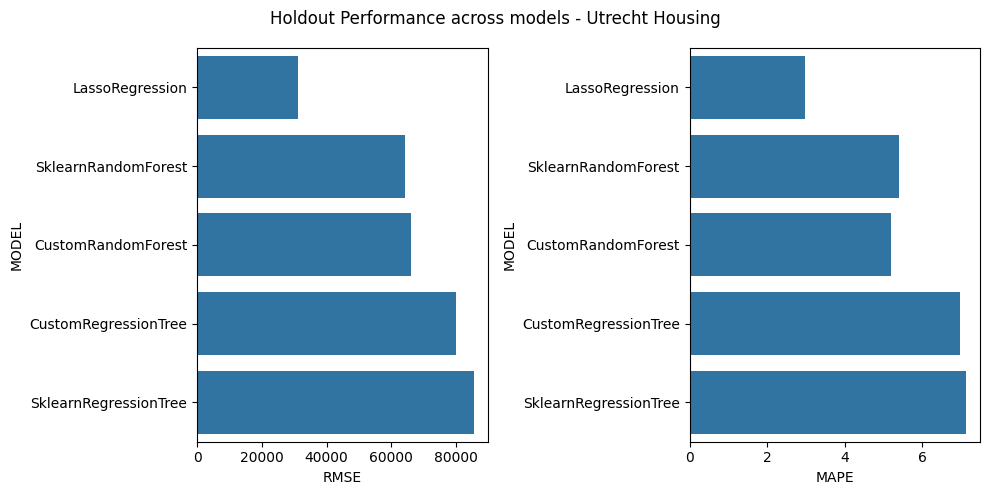

In [83]:
df_report = pd.DataFrame([
    {"MODEL": "CustomRegressionTree", "RMSE": custom_reg_tree_metrics["RMSE"], "MAPE": custom_reg_tree_metrics["MAPE"]},
    {"MODEL": "SklearnRegressionTree", "RMSE": reg_tree_metrics["RMSE"], "MAPE": reg_tree_metrics["MAPE"]},
    {"MODEL": "CustomRandomForest", "RMSE": custom_rand_forest_metrics["RMSE"], "MAPE": custom_rand_forest_metrics["MAPE"]},
    {"MODEL": "SklearnRandomForest", "RMSE": rand_forest_metrics["RMSE"], "MAPE": rand_forest_metrics["MAPE"]},
    {"MODEL": "LassoRegression", "RMSE": lasso_metrics["RMSE"], "MAPE": lasso_metrics["MAPE"]},
])
df_report = df_report.sort_values(by="RMSE")

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.barplot(data=df_report, y="MODEL", x="RMSE", ax=ax[0])
sns.barplot(data=df_report, y="MODEL", x="MAPE", ax=ax[1])
plt.suptitle("Holdout Performance across models - Utrecht Housing");
plt.tight_layout()